# Wavegeometry model pre-process

Prepare the basic state in a zonally averaged atmosphere as input for the wavegeometry model by Nili Harnik and collegues.

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from dask.distributed import Client

In [3]:
%cd /s2s/wwicker/wavegeometry_model/src
from basicstate import Grid, interp2z, buoancy_frequency, pv_gradient

/s2s/wwicker/wavegeometry_model/src


In [87]:
# Input filenames
u_files = ['/s2s/wwicker/data/20180125_91L/pressure_levels/u/',
           '/s2s/wwicker/data/20180208_91L/pressure_levels/u/',
           '/s2s/wwicker/data/20181213_91L/pressure_levels/u/',
           '/s2s/wwicker/data/20190108_91L/pressure_levels/u/'
           ]
u_files = [sorted([d+f for f in os.listdir(d) if f.endswith('.grb')]) for d in u_files]
t_files = ['/s2s/wwicker/data/20180125_91L/pressure_levels/t/',
           '/s2s/wwicker/data/20180208_91L/pressure_levels/t/',
           '/s2s/wwicker/data/20181213_91L/pressure_levels/t/',
           '/s2s/wwicker/data/20190108_91L/pressure_levels/t/',
           ]
t_files = [sorted([d+f for f in os.listdir(d) if f.endswith('.grb')]) for d in t_files]
namelist = '/s2s/wwicker/wavegeometry_model/input/nml-IFS-pressure-level'

outfile = '/s2s/wwicker/wavegeometry_model/input/IFS-pressure-level-91L.nc'

### Pre-process

In [5]:
%cd /s2s_nobackup/wwicker
client = Client(n_workers=4,threads_per_worker=4,memory_limit='32G')
client

/s2s_nobackup/wwicker


Client Scheduler: tcp://127.0.0.1:45461 Dashboard: /user/wwicker/proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 119.21 GiB


In [53]:


# Derive zonal mean from netcdf files
# Use Numpy arrays
ds = xr.open_mfdataset(u_files,engine='cfgrib',combine='nested',concat_dim=['time','number'])
uobs = ds['u'].sel(latitude=slice(90,0)).mean('longitude')
uobs = uobs.mean(('time','number','step'))
uobs = np.flip(uobs.values,-1)[np.newaxis,:,:]

ds = xr.open_mfdataset(t_files,engine='cfgrib',combine='nested',concat_dim=['time','number'])
tobs = ds['t'].sel(latitude=slice(90,0)).mean('longitude')
tobs = tobs.mean(('time','number','step'))
tobs = np.flip(tobs.values,-1)[np.newaxis,:,:]

pressure = ds['isobaricInhPa'].values
lat = np.flip(ds.latitude.sel(latitude=slice(90,0)).values,-1)

client.close()

In [80]:
# read the namelist and define model grid
grid = Grid(namelist)

# interpolate u & t from pressure to z-coordinates with constant grid spacing
# this involves smoothin$g by convolution with 
u = interp2z(grid,uobs,pressure,nfilter=2)
t = interp2z(grid,tobs,pressure,nfilter=10)

In [81]:
# calculate squared buoancy frequency and pv gradient from in-situ temperature and zonal wind
N2 = buoancy_frequency(grid,t)
qy = pv_gradient(grid,u,N2)

In [82]:
# Fill NaNs in u, N2, and qy
def forward_fill(arr):
    '''
        found on stackoverflow
    '''
    df = pd.DataFrame(arr)
    df.fillna(method='ffill', axis=0, inplace=True)
    out = df.to_numpy()
    return out

for step in grid.t:
    u[step,:,:] = forward_fill(u[step,:,:])
    N2[step,:,:] = forward_fill(N2[step,:,:])
    qy[step,:,:] = forward_fill(qy[step,:,:])

### Plot basic state

Choose either time mean or random timestep

- interp2z fills out of bounds with np.nan
- each convolution extends the area with np.nan
- NaNs are filled for u, N2, and qy

In [83]:
# choose either time mean or random timestep
step = np.random.randint(0,len(grid.t))
#choose = lambda a: a[step,:,:]
choose = lambda a: a.mean(axis=0)
#choose = lambda a: a

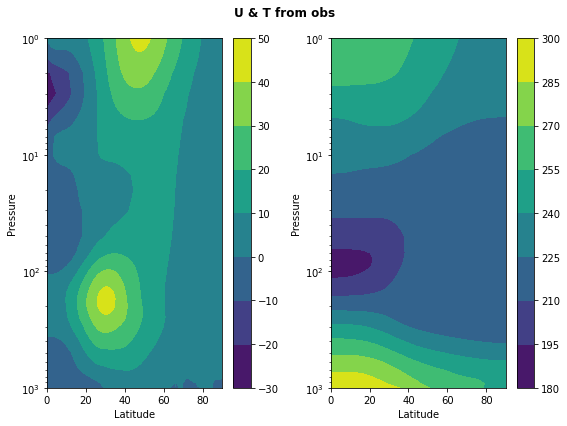

In [88]:
# plot U & T from obs
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(lat,pressure,choose(uobs))
axes[0].set_ylim(axes[0].get_ylim()[::-1])
axes[0].set_yscale('log')
axes[0].set_ylabel('Pressure')
axes[0].set_xlabel('Latitude')
plt.colorbar(Cs,ax=axes[0])
                   
Cs = axes[1].contourf(lat,pressure,choose(tobs))
axes[1].set_ylim(axes[1].get_ylim()[::-1])
axes[1].set_yscale('log')
axes[1].set_ylabel('Pressure')
axes[1].set_xlabel('Latitude')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('U & T from obs',weight='bold')
fig.tight_layout()

plt_dir = '/s2s/wwicker/plots/wavegeometry_model/'
plt.savefig(plt_dir+'IFS-pressure-level-91L_obs.png',dpi=300)

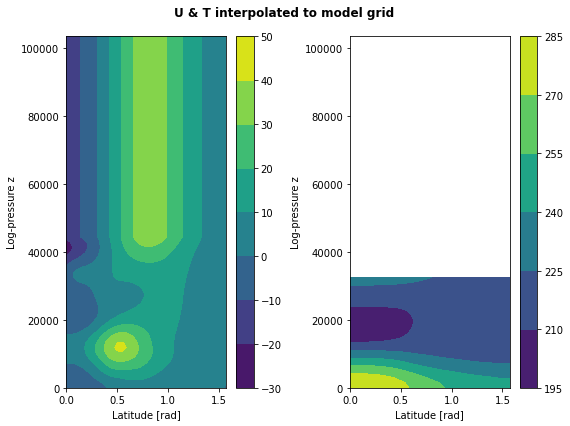

In [89]:
# plot U & T on model grid
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,choose(u))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

Cs = axes[1].contourf(grid.y,grid.z,choose(t))
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('U & T interpolated to model grid',weight='bold')
fig.tight_layout()

plt_dir = '/s2s/wwicker/plots/wavegeometry_model/'
plt.savefig(plt_dir+'IFS-pressure-level-91L_model_grid.png',dpi=300)

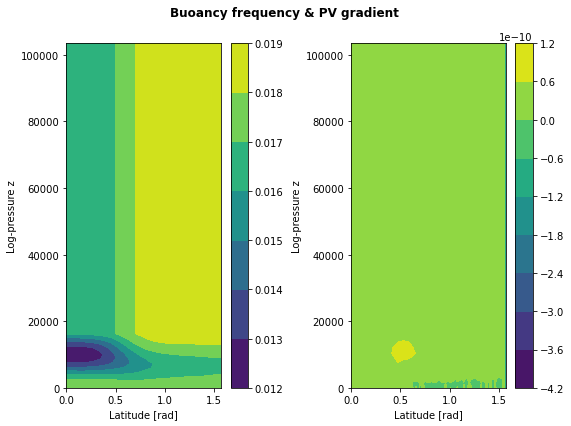

In [90]:
# plot buoancy frequency and pvgradient
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,np.sqrt(choose(N2)))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

Cs = axes[1].contourf(grid.y,grid.z,choose(qy))
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('Buoancy frequency & PV gradient',weight='bold')
fig.tight_layout()

plt_dir = '/s2s/wwicker/plots/wavegeometry_model/'
plt.savefig(plt_dir+'IFS-pressure-level-91L_basicstate.png',dpi=300)

### Store basic state to outfile

In [91]:
u = xr.DataArray(u,dims=('step','lev','lat'),coords=dict(step=grid.t,lev=grid.z,lat=grid.y),name='u')

qy = xr.DataArray(qy,dims=('step','lev','lat'),coords=dict(step=grid.t,lev=grid.z,lat=grid.y),name='qy')

N2 = xr.DataArray(N2,dims=('step','lev','lat'),coords=dict(step=grid.t,lev=grid.z,lat=grid.y),name='N2')

xr.merge([u,qy,N2]).to_netcdf(outfile,unlimited_dims='step')